## 1. Importing Dependencies

In [2]:
import os
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

## 2. Loading the Data

In [3]:
outcomes_df = pd.read_csv("../data/01-raw/actual_outcomes.csv")
features_df = pd.read_csv("../data/01-raw/customer_features.csv")
predictions_df = pd.read_csv("../data/01-raw/model_predictions.csv")
retention_df = pd.read_csv("../data/01-raw/retention_campaigns.csv")

#### I.**customer\_features.csv** - Customer characteristics (5,000 customers)

In [4]:
features_df

,customer_id,account_age_days,age,county,avg_monthly_transactions,avg_transaction_value,wallet_balance,days_since_last_transaction
0,CUST00001,258,20,Nairobi,23.250880,2950.869798,38141.204637,0
1,CUST00002,221,55,Nakuru,14.064263,566.339924,2388.957682,6
2,CUST00003,43,39,Nairobi,4.117615,807.137278,905.826891,11
3,CUST00004,219,52,Nairobi,12.307753,1359.889306,3012.948239,0
4,CUST00005,805,63,Nairobi,23.795348,5586.158697,44845.328657,2
...,...,...,...,...,...,...,...,...
4995,CUST04996,570,31,Kiambu,3.703784,624.576881,2899.269832,16
4996,CUST04997,773,34,Kisumu,32.177664,2037.876018,11132.849408,3
4997,CUST04998,304,38,Kisumu,2.772267,801.531789,697.358383,7
4998,CUST04999,656,34,Kiambu,4.157972,907.384954,780.885453,16


#### II. **model\_predictions.csv** - Model output from 3 months ago

In [5]:
predictions_df

,customer_id,model_churn_probability,contacted,offer_type,responded
0,CUST00001,0.671539,True,Zero fee week,False
1,CUST00002,0.495458,False,NaN,False
2,CUST00003,0.770404,True,Zero fee week,False
3,CUST00004,0.555735,False,NaN,False
4,CUST00005,0.334440,False,NaN,False
...,...,...,...,...,...
4995,CUST04996,0.736526,True,Cashback 100 KES,True
4996,CUST04997,0.539012,False,NaN,False
4997,CUST04998,0.821544,True,Cashback 100 KES,False
4998,CUST04999,0.718044,True,Cashback 100 KES,False


#### III. **retention\_campaigns.csv** - Who was contacted and how they responded

In [6]:
retention_df

,customer_id,contacted,offer_type,responded,actual_churned,model_churn_probability,true_segment
0,CUST00001,True,Zero fee week,False,False,0.671539,High Value Active
1,CUST00003,True,Zero fee week,False,False,0.770404,Casual User
2,CUST00006,True,Airtime bonus 50 KES,False,False,0.724132,Casual User
3,CUST00009,True,Cashback 100 KES,False,True,0.759133,Casual User
4,CUST00011,True,Zero fee week,False,True,0.846534,Recent Signup
...,...,...,...,...,...,...,...
2704,CUST04993,True,Cashback 100 KES,False,False,0.922074,Casual User
2705,CUST04995,True,Cashback 100 KES,False,False,0.837452,Casual User
2706,CUST04996,True,Cashback 100 KES,True,False,0.736526,Casual User
2707,CUST04998,True,Cashback 100 KES,False,True,0.821544,Recent Signup


#### IV. **actual\_outcomes.csv** - Who actually churned (3 months later)

In [7]:
outcomes_df

,customer_id,actual_churned
0,CUST00001,False
1,CUST00002,False
2,CUST00003,False
3,CUST00004,False
4,CUST00005,False
...,...,...
4995,CUST04996,False
4996,CUST04997,False
4997,CUST04998,True
4998,CUST04999,False


## 3. Investigations

In this segment, I try investigate why an **87% accuracy model** is performing poorly in production, ie the Prediction and reality outcome mis-match. 

#### I. Data integration and Alignment

I'll join the features the prediction made 3 months ago and the actual results that happened since then.By joining the **prediction_df** and **outcome_df**,  I create dataframe where every row has **model_churn_probability** and **actual_outcome**.

In [8]:
# merge the data
evaluation_df = pd.merge(predictions_df,outcomes_df, on='customer_id')

print(f"Rows in evaluation_df {len(evaluation_df)}")
evaluation_df

Rows in evaluation_df 5000


,customer_id,model_churn_probability,contacted,offer_type,responded,actual_churned
0,CUST00001,0.671539,True,Zero fee week,False,False
1,CUST00002,0.495458,False,NaN,False,False
2,CUST00003,0.770404,True,Zero fee week,False,False
3,CUST00004,0.555735,False,NaN,False,False
4,CUST00005,0.334440,False,NaN,False,False
...,...,...,...,...,...,...
4995,CUST04996,0.736526,True,Cashback 100 KES,True,False
4996,CUST04997,0.539012,False,NaN,False,False
4997,CUST04998,0.821544,True,Cashback 100 KES,False,True
4998,CUST04999,0.718044,True,Cashback 100 KES,False,False


In [9]:
# apply the production threshold
evaluation_df['predicted_churn'] = evaluation_df['model_churn_probability'] >= 0.6
evaluation_df

,customer_id,model_churn_probability,contacted,offer_type,responded,actual_churned,predicted_churn
0,CUST00001,0.671539,True,Zero fee week,False,False,True
1,CUST00002,0.495458,False,NaN,False,False,False
2,CUST00003,0.770404,True,Zero fee week,False,False,True
3,CUST00004,0.555735,False,NaN,False,False,False
4,CUST00005,0.334440,False,NaN,False,False,False
...,...,...,...,...,...,...,...
4995,CUST04996,0.736526,True,Cashback 100 KES,True,False,True
4996,CUST04997,0.539012,False,NaN,False,False,False
4997,CUST04998,0.821544,True,Cashback 100 KES,False,True,True
4998,CUST04999,0.718044,True,Cashback 100 KES,False,False,True


#### II. The Confusion Matrix

*   **True Positives (TP):** People the model said would churn, and they did. (Success)
    
*   **False Positives (FP):** People the model said would churn, but they stayed. (**The "Waste"**: We spent marketing budget on these people for no reason).
    
*   **False Negatives (FN):** People the model said would stay, but they churned. (**The "Leak"**: These are the people the Head of Retention is "hemorrhaging").
    
*   **True Negatives (TN):** People the model said would stay, and they stayed. (The "Safe" zone).

In [10]:
# Compute confusion matrix values
tn, fp, fn, tp = confusion_matrix(
    evaluation_df['actual_churned'],
    evaluation_df['predicted_churn']
).ravel()

# Create simple confusion matrix table
cm_table = pd.DataFrame(
    [[tn, fp],
     [fn, tp]],
    index=["Actual: Not Churned", "Actual: Churned"],
    columns=["Predicted: Not Churned", "Predicted: Churned"]
)
print(f"Total Customers: {len(evaluation_df)}")
print(cm_table)
print(f"Missed Churners (False Negatives) {fn}")
print(f"Wasted marketing (False Positive) {fp}")

Total Customers: 5000
                     Predicted: Not Churned  Predicted: Churned
Actual: Not Churned                    1601                2035
Actual: Churned                         197                1167
Missed Churners (False Negatives) 197
Wasted marketing (False Positive) 2035


#### III. Classification Report

In [20]:
# generate the report
print("---Classification Report---")
print(classification_report(evaluation_df['actual_churned'],evaluation_df['predicted_churn']))

---Classification Report---
              precision    recall  f1-score   support

       False       0.89      0.44      0.59      3636
        True       0.36      0.86      0.51      1364

    accuracy                           0.55      5000
   macro avg       0.63      0.65      0.55      5000
weighted avg       0.75      0.55      0.57      5000



1\. Accuracy (55%) - Percentage of all predictions that were correct
    
*   **Meaning:** Only 55% of the total predictions were right.
    
*   **Context:** The "87% accuracy" the consultancy promised is gone. This model is barely outperforming a coin flip because it is guessing "Churn" far too often.
    
2\. Precision (36%) - Of all the people the model claimed would **Churn**, how many actually did?
    
*   **Meaning:** When the model flags a churner, it is **wrong 64% of the time**.
    
*   **Context:** Head of Retention targeted **3,399 people the model said would churn** (TP + FP), but **2,035** of them (The Waste) had no intention of leaving. Free airtime and cashback  was sent to 2,035 loyal customers who didn't need it.
    
3\. Recall (86%) - Of all the people who actually churned, how many did the model catch?
    
*   **Meaning:** The model caught 86% of the people who actually left.
    
*   **Context:** Out of 1,364 actual churners, The model caught **1,167** (The Wins). The model didn't catch (hemorrhaged) **197** people (The Leak).
    
*   **The Catch:** To get this high safety rating, the model is being way too aggressive, causing the massive "Waste" mentioned above.
    
4\. F1-Score (0.51) - The harmonic mean of Precision and Recall. It’s a single number that punishes extreme values.
    
*   **Meaning:** The middle ground between Precision and Recall.
    
*   **Context:** Since the models Precision is terrible (0.36) and the Recall is good (0.86), the F1-score is low. A "healthy" model would ideally have both above 0.70.

#### IV. Precision-Recall Curve.

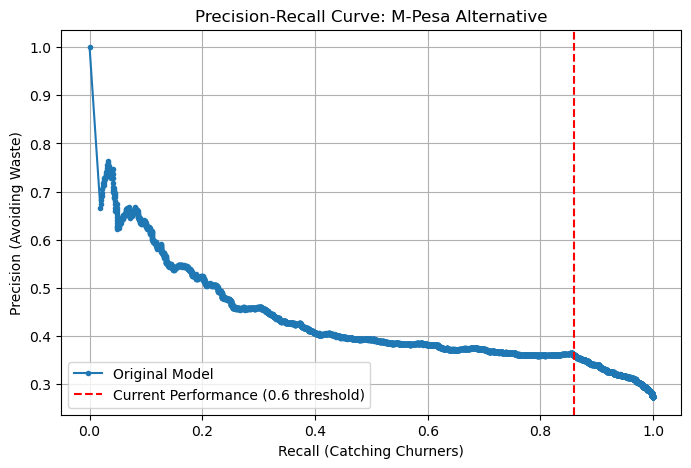

In [11]:
# Calculate the values for the curve
# Use the raw probabilities rather than the True/False labels
precision, recall, threshold = precision_recall_curve(evaluation_df['actual_churned'], evaluation_df['model_churn_probability'])

# plotting
plt.figure(figsize=(8, 5))
plt.plot(recall,precision,marker='.',label='Original Model')
plt.xlabel('Recall (Catching Churners)')
plt.ylabel('Precision (Avoiding Waste)')
plt.title('Precision-Recall Curve: M-Pesa Alternative')
plt.axvline(x=0.86, color='r', linestyle='--', label='Current Performance (0.6 threshold)')
plt.legend()
plt.grid()
plt.show()

### The Analysis
#### I. Safety vs Sustainability
The current threshold of **0.6** prioritizes **safety(Catching everyone)** over **Sustainability(Spending wisely)**
By trying to capture **86%** of all **potential Churners** the **precision** has dropped to around **36%**...ie. For every **10 people** the **model flags**, only about **3 or 4 actually churn**. This explains why the **Head of Retention** feels the model is targeting the **wrong people** because technically, it is.

#### II. Diminishing Returns
The Graph shows a "Flat Zone" between **40% and 86% recall**
Increasing the catch rate in this area doesn't make the model smarter, it just makes the net wider.
To catch those last few hundred churners, the company is forced to accept thousands of **False Positives** (loyal users who get freebies they didn't need). This is the "Waste" that is burning the marketing budget.

#### III. Sweet Spot
There is a spike on the far left of the graph where precision hits **0.75**. Instead of using a giant messy net that takes everything with it, this spike shows that we have a **Smaller, high-tech net**.It only looks at "Top 10-20%" of users who look the most suspicious, the ones who haven't logged in for days or just emptied their wallets. The team focuses on these "High-Certainty" users, and the response rate increases because we are finally targeting people who were on the verge of leaving.